# ✔	 - Import modules -

In [1]:
import os
import time
import numpy as np
import random
from matplotlib import pyplot as plt
from math import exp, cos
import json
from tqdm import tqdm
import matplotlib.cm as cm
import scipy.stats as stats

# ✔	 - Function definition -

# ✘ Corrected Input function

In [2]:
# Function returning the corrected Input
def Ic(Input=0):
    if Input <= 0:
        return 0
    else:
        return (Input)

# ✘ Activity at time t-Delta (delay) function

In [3]:
# function to get the index "-delay/dt" in the list representing m(t-Delta)
def mdelta(synapse_value, delay, t, dt,i):
    if t < delay:  # if the delay is the time is too small, we take m(t-delta)=0
        return 0
    else:  # if the time is above or equal to the delay, we can find the m(t-delta)
        return synapse_value[int(-delay / dt)][i]

# ✘ Plotting functions (Inputs & activities) and data folder creation function

In [4]:
def Inplot(x,data,title):    # plot the external Inputs
    ind=np.arange(len(data))
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.barh(ind, data, 0.899,color='g')
    ax.set_yticks(ind)
    r = ax.set_yticklabels(x, ha = 'left',fontsize = 16)
    fig.set_size_inches(15, 2, forward=True)
    
    plt.draw()
    yax = ax.get_yaxis()
    pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
    yax.set_tick_params(pad=pad,)
    
    ######################################## Annotations on plot #############################################
    bbox_props = dict(boxstyle="round4,pad=0.3", fc="white", ec="k", lw=2)
    t = ax.text(H['Gpe'], 1, str(H['Gpe']), ha="center", va="center", rotation=5,
            size=12,
            bbox=bbox_props) 
    bbox_props = dict(boxstyle="round4,pad=0.3", fc="white", ec="k", lw=2)
    t = ax.text(H['Fsi'], 2, str(H['Fsi']), ha="center", va="center",rotation=5,
            size=12,
            bbox=bbox_props) 
    bbox_props = dict(boxstyle="round4,pad=0.3", fc="white", ec="k", lw=2)
    t = ax.text(H['Msn'], 0, str(H['Msn']), ha="center", va="center",rotation=5,
            size=12,
            bbox=bbox_props) 
    ##########################################################################################################
    ax=plt.gca()
    col_labels=['Fsi','Msn','Gpe']
    row_labels=['G (Weight)','Basal Activity (spk/s)']          
    table_vals=[[str(G['MsnFsi']),str(G['GpeMsn']),str(G['FsiGpe'])],
                [str(M['MsnFsi']),str(M['GpeMsn']),str(M['FsiGpe'])]]
    
    table=plt.table(cellText=table_vals,
        colWidths = [0.4]*3,
        rowLabels=row_labels,
        colLabels=col_labels,
        loc='bottom',bbox=[0.4, -0.65, 0.2, 0.3])
    table.set_fontsize(10)

    plt.draw()
    plt.grid()
    plt.xlabel('spike per second (spk/s)')
    plt.ylabel('structures')
    plt.title('External Input value for each structure')

In [5]:
def plotting(k,typ, title, xax, yax, element, source,value, v1, v2, v3,On):# plot activity and input dynamics 
    fig = plt.figure(figsize=(15,10))
    ax=fig.add_subplot(111) 
    
    for element in source:
        value[element]=np.zeros(n_period)
        
        for t in range(0,n_period):
            if On == 0:
                value[element][t] = typ[element][t][k]
            else:
                value[element][t] = np.mean(typ[element][t])     

        ax.plot(time_value, value[element], label= str(element), alpha=0.7)   
        ax.set_title((title + ' {}'.format(k+1)))
        ax.set_ylabel(yax), ax.set_xlabel(xax), ax.grid()
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,prop={'size':15})
    
    ax=plt.gca()
    col_labels=['Fsi','Msn','Gpe']
    row_labels=['G (Weight)','Min','Mean','Max','Var','Stand.Dev']          
    table_vals=[[str(G['MsnFsi']),str(G['GpeMsn']),str(G['FsiGpe'])],
                [np.amin(value[v1]),np.amin(value[v2]),np.amin(value[v3])],
                [np.mean(value[v1]),np.mean(value[v2]),np.mean(value[v3])],
                [np.amax(value[v1]),np.amax(value[v2]),np.amax(value[v3])],
                [np.var(value[v1]),np.var(value[v2]),np.var(value[v3])],
                [np.std(value[v1]),np.std(value[v2]),np.std(value[v3])]]
    
    table=plt.table(cellText=table_vals,
        colWidths = [0.8]*5,
        rowLabels=row_labels,
        colLabels=col_labels,
        loc='bottom',bbox=[0.27, -0.4, 0.6, 0.3])
    table.set_fontsize(20)

In [6]:
def data_dir(dir="os.getcwd()"):            # will create the files needed to store values in CWD/Data
    if not os.path.exists('{}/{}'.format(os.getcwd(),'DataFsi')): # will be used to tag simulation results
        directory = os.path.dirname(dir)
        os.makedirs('{}/{}'.format(os.getcwd(),'DataFsi'))
    if not os.path.exists('DataFsi/{}'.format(timestr)):
        os.makedirs('DataFsi/{}'.format(timestr))

In [7]:
def Spectrum(): # Plot the spectrum and return the plot of 3 populations
    col=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    FourNo = dict()
    fourier= dict()
    freq=dict()
#=========================================================================================

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle("Discrete fourier transform of Outputs",y=1.05, fontsize=20)

    i=0
    for con in connections:
        FourNo[con]=Mean[con] - np.mean(Mean[con])
#=========================================================================================

#Calculating FFT of signal
        fourier[con]=np.fft.fft(FourNo[con])/len(FourNo[con])
        freq[con]=np.fft.fftfreq(fourier[con].shape[0],dt)

        toc=np.argmax(abs(fourier[con]))
    
#Plotting FFT of signal
        axes[i].plot(freq[con],abs(fourier[con]),label=str(abs(freq[con][toc]))+' Hz',
                 color=col[i+2])
        axes[i].set_title(con + ' Dominant frequency oscillation')
        axes[i].set_xlabel('spectrum range (Hz)')
        axes[i].set_xlim(0,50)
        axes[i].set_ylabel('Amplitude (normalized)')
        axes[i].legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0. , fontsize=17)
        i+=1
            
    plt.savefig('DataFsi/{}/FFT_{}.png'.format(timestr,'Mean'),dpi=300,bbox_inches='tight')
    plt.show()

# ✔	 - Initial parameters - 

In [8]:
## Population size (number of neuron)
n = 100

## Default Time beginning (second)
t = 0

## Default trial duration (second)
duration = 1.00   

## Default Time resolution (second)
dt = 0.0001  # 0.00001

## Period occuring 
n_period = int(duration // dt) + 1

## Initialization of the random generator (reproductibility)
np.random.seed(1)

In [9]:
time_value = np.arange(0, duration, dt) # creat the timescale, depending on the duration and step dt, for plotting

In [10]:
## creation of dict to store m, dm, J, H and input I values
Mean, m, dm, J, H, y,value,I = dict(),dict(), dict(), dict(), dict(), dict(), dict(), dict()

In [11]:
connections = ["GpeMsn", "FsiGpe", "MsnFsi"]
structures = ["Msn", "Fsi", "Gpe"]

In [12]:
 ## Fixed point activity: (IN VIVO Values needed)
M = {                     
    "GpeMsn": 1,   # spikes/s
    "MsnFsi": 3,   # spikes/s
    "FsiGpe": 20   # spikes/s
}

 ## Weights (connextions pre->post ; notation: PostPre):
G = {
    "GpeMsn": 1.00,
    "FsiGpe": 1.00,
    "MsnFsi": 1.00,     # sa depend de la racine cubique
}

 ## Tau:
tau = {
    "GpeMsn": 0.0200,
    "FsiGpe": 0.0050, #0.005
    "MsnFsi": 0.0050, #0.005
}

 ## Delays:
D = {
    "GpeMsn": 0.0070, # 7ms: Jaeger & Kita, 2011 ; (in vivo-rat & monkey)
    "FsiGpe": 0.0070, # 1ms: Jaeger & Kita, 2011 ; (in vivo-rat & monkey)
    "MsnFsi": 0.0008, # 0.8ms: Gittis et al., 2010 ; (in vitro - mice)
}

 ## Connection probability:
C = {
    "GpeMsn": 1.00, #alltoall
    "FsiGpe": 1.00,
    "MsnFsi": 1.00, #alltoall
}

 ## External Input, calculated and constant all over the simulation
H = {
    "Msn": M['GpeMsn']+G['MsnFsi']*M['MsnFsi'],   
    "Fsi": M['MsnFsi']+G['FsiGpe']*M['FsiGpe'],   
    "Gpe": M['FsiGpe']+G['GpeMsn']*M['GpeMsn']
}

 ## Noise (sigma):
N = {
    "Msn":H['Msn']/20,   
    "Fsi":H['Fsi']/20,   
    "Gpe":H['Gpe']/20
}

In [13]:
input_mapping = {
    "Msn": "MsnFsi",
    "Gpe": "GpeMsn",
    "Fsi": "FsiGpe"
}

activities_mapping = {
    "GpeMsn": "Msn",
    "FsiGpe": "Gpe",
    "MsnFsi": "Fsi"
}

In [14]:
## create an array of 'nperiod' array (store value trought time) with n zeroes in
for con in connections:   
    m[con] = np.zeros((n_period, n))
   
    y[con]=int(D[con]//dt)
    m[con][0:y[con]]= M[con] #    m[con][0:y[con]:n]?
## create an array composed of     
    dm[con] = np.zeros((n_period, n))
## create an array composed of 0 & 1 depending on the probability "Co"(max=1=100%)
    J[con] = np.random.choice(2, size=(n, n), p=[(1-C[con]),C[con]])

In [15]:
 ## Noise (sigma):
TN = {
    "Msn": H["Msn"]/1,   
    "Fsi": H["Fsi"]/30,   
    "Gpe": H["Gpe"]/30
}

In [16]:
T = dict()

In [17]:
## inputs array generation: noises picked (N=sigma)
for stc in structures:                                                              
    T[stc]=np.random.normal(0, TN[stc] , size=n)
    I[stc] = np.random.normal(0, N[stc], size=(n_period, n)) + H[stc] + T[stc]

# ✔	 - Simulation Core -

In [18]:
for t in tqdm(range(1, n_period)):    ## Update of Inputs
    
    for stc in structures:
        for i in range(n):
            con = input_mapping[stc] #multiplication by the probability of connexion below with n
            I[stc][t][i] += - np.sum(G[con]* mdelta(m[con][:t + 1], D[con], time_value[t], dt,i) *J[con][i])/n              

                
    for con in connections:          ## Update of activities
        for i in range(n):
            stc = activities_mapping[con]
            dm[con][t][i] = dt * (- m[con][t][i] + Ic(I[stc][t][i])) / tau[con]
            
        if t < n_period-1: # we can't add last value of dm to the last value of m
            m[con][t+1]=m[con][t]+dm[con][t]
        else:
            continue

100%|██████████| 9999/9999 [00:23<00:00, 421.43it/s]


# ✔	 - Result Plots & Save data -

In [19]:
timestr = time.strftime("%Y-%m-%d-%H:%M:%S") # give the date and time used to tag simulation results
data_dir()  # creating the 'Data' directory on CWD and the directory (with date & time) to store the results

for stc in structures:  # save the Input array (npy format) for each neuron population in "structures"
    np.save('DataFsi/{}/{}_Inputs'.format(timestr, stc), I[stc])
    
for con in connections: # save the Activity array (npy format) for each neuron population in "connections"
    np.save('DataFsi/{}/{}_Activities'.format(timestr, con), m[con])

datax={'Weight':G,'Delay':D,'tau':tau,'Noise':N,'BasalActivity':M,'ConnexProba':C,  # make one dict with all parameters used 
       'ExternalInput':H,'Neuron_number':n,'time_trial':t,'duration':duration,'step':dt}

with open('DataFsi/{}/0_Parameters.json'.format(timestr),'w') as f: # save the parameters used during the simulation
            json.dump(datax, f) 

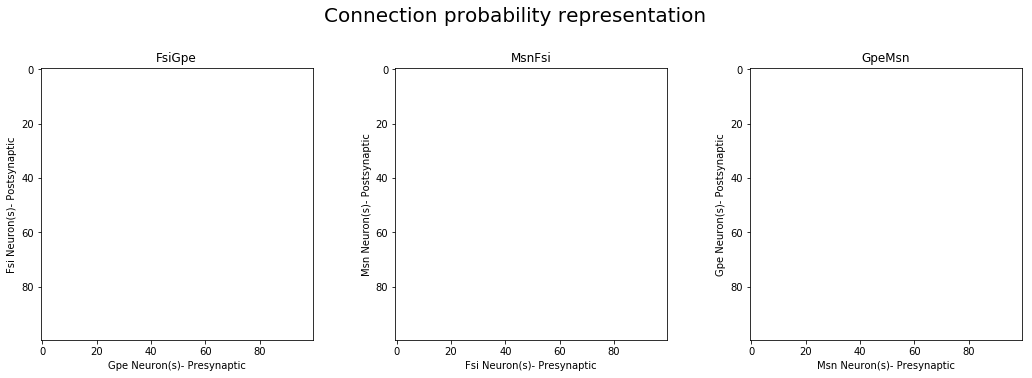

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Connection probability representation",y=1.05, fontsize=20)

axes[0].imshow(J["FsiGpe"], cmap='Greys',  interpolation='nearest')
axes[0].set_title("FsiGpe")
axes[0].set_xlabel("Gpe Neuron(s)- Presynaptic")
axes[0].set_ylabel("Fsi Neuron(s)- Postsynaptic")

    
axes[1].imshow(J["MsnFsi"], cmap='Greys',  interpolation='nearest')
axes[1].set_title("MsnFsi")
axes[1].set_xlabel("Fsi Neuron(s)- Presynaptic")
axes[1].set_ylabel("Msn Neuron(s)- Postsynaptic")

    
axes[2].imshow(J["GpeMsn"], cmap='Greys',  interpolation='nearest')
axes[2].set_title("GpeMsn")
axes[2].set_xlabel("Msn Neuron(s)- Presynaptic")
axes[2].set_ylabel("Gpe Neuron(s)- Postsynaptic")

plt.savefig('DataFsi/{}/C{}.png'.format(timestr,con),dpi=300,bbox_inches='tight')
plt.show()

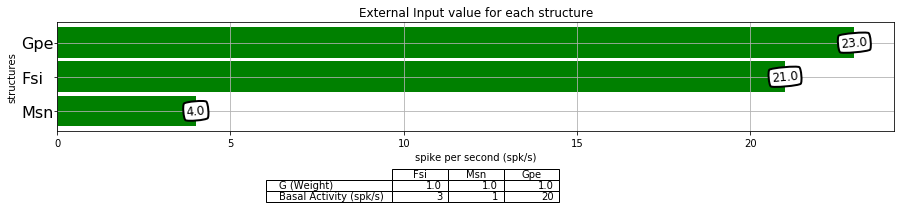

In [21]:
## Plotting EXTERNAL INPUTS
Inplot(structures,[H['Msn'],H['Gpe'],H['Fsi']],'External Input value for each structure')
plt.savefig('DataFsi/{}/0_H.png'.format(timestr),dpi=300,bbox_inches='tight')
plt.show()

# ✔	 - Mean firing rate plotting - 

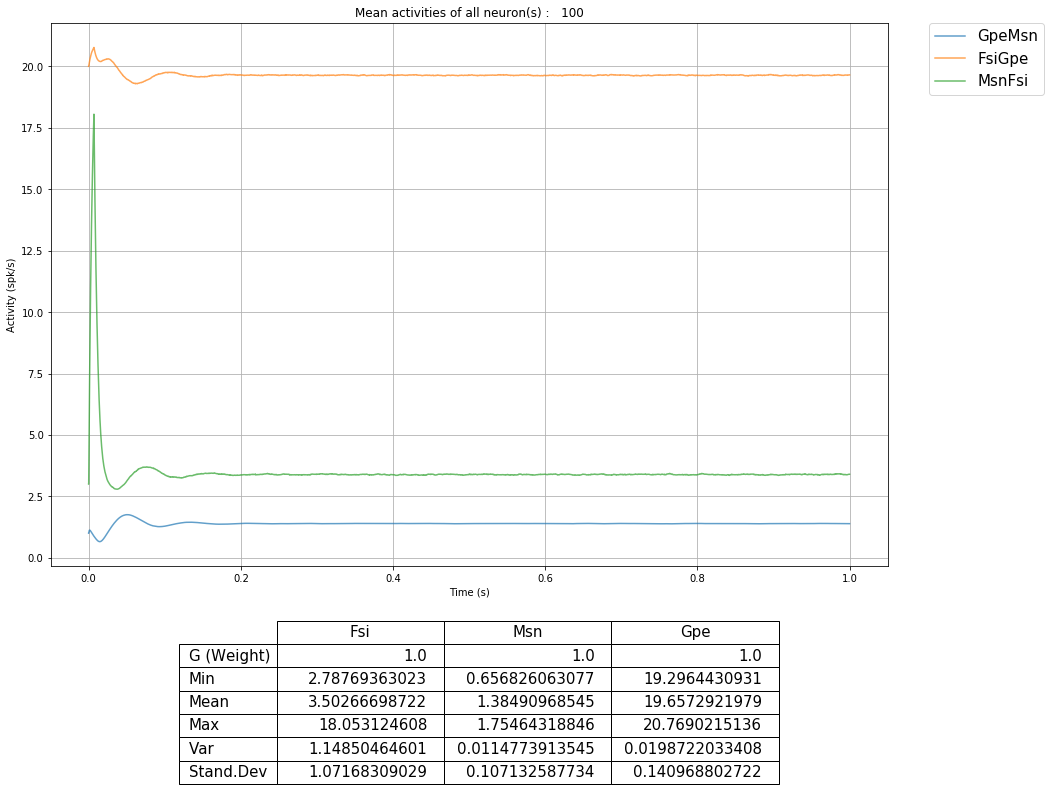

In [22]:
## Ploting the mean activity of the n neuron
plotting(n-1, m, 'Mean activities of all neuron(s) :  ', 'Time (s)','Activity (spk/s)', con, connections,Mean, 'MsnFsi', 'GpeMsn','FsiGpe',On=1)
plt.savefig('DataFsi/{}/{}_Mean_Activities.png'.format(timestr,'0'),dpi=300,bbox_inches='tight')
plt.show()

# ✔	 -  Fourier transform (DFT): Spectrum analysis

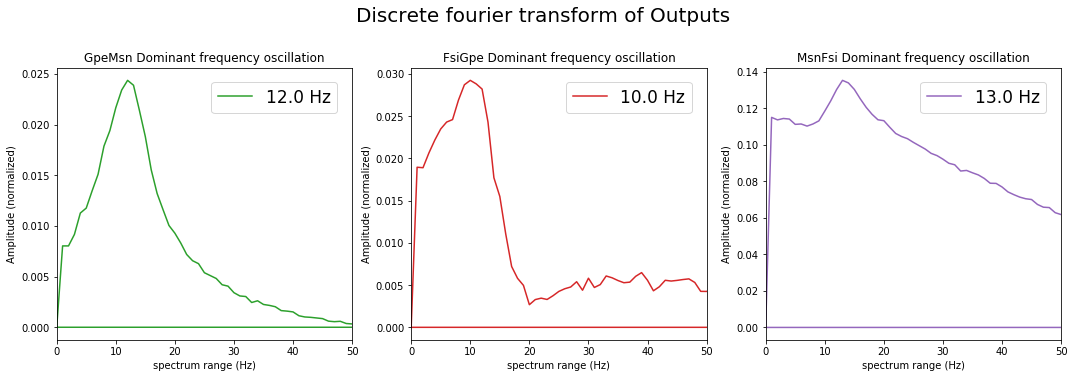

In [23]:
Spectrum()

# ✔	 -  Population analysis

100%|██████████| 100/100 [00:01<00:00, 88.25it/s]


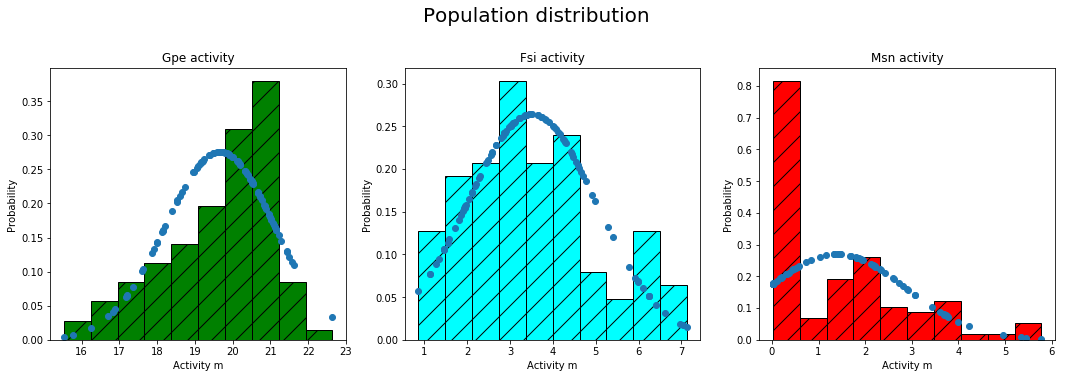

In [24]:
moyFsiGpe=[]
moyGpeMsn=[]
moyMsnFsi=[]

supmoyFG=[]
supmoyGM=[]
supmoyMF=[]

for k in tqdm(np.arange(0,n,1)): 
    moyFsiGpe=[]
    moyGpeMsn=[]
    moyMsnFsi=[]
    for t in range(0,n_period):
        moyFsiGpe.append(m['FsiGpe'][t][k])
        moyGpeMsn.append(m['GpeMsn'][t][k])
        moyMsnFsi.append(m['MsnFsi'][t][k])

    supmoyFG.append(np.mean(moyFsiGpe))
    supmoyGM.append(np.mean(moyGpeMsn))
    supmoyMF.append(np.mean(moyMsnFsi))
             
            
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Population distribution",y=1.05, fontsize=20)

fit1 = stats.norm.pdf(supmoyFG, np.mean(supmoyFG), np.std(supmoyFG))  #this is a fitting indeed
fit2 = stats.norm.pdf(supmoyMF, np.mean(supmoyMF), np.std(supmoyMF))  #this is a fitting indeed
fit3 = stats.norm.pdf(supmoyGM, np.mean(supmoyGM), np.std(supmoyGM))  #this is a fitting indeed


axes[0].hist(supmoyFG,normed=True,edgecolor='black',color ='green', hatch = '/')
axes[0].plot(supmoyFG,fit1, 'o')
axes[0].set_title("Gpe activity")
axes[0].set_xlabel("Activity m")
axes[0].set_ylabel('Probability')

    
axes[1].hist(supmoyMF,normed=True,edgecolor='black',color ='cyan', hatch = '/')  
axes[1].plot(supmoyMF,fit2, 'o')
axes[1].set_title("Fsi activity")
axes[1].set_xlabel("Activity m")
axes[1].set_ylabel('Probability')

    
axes[2].hist(supmoyGM,normed=True,edgecolor='black',color ='red', hatch = '/')
axes[2].plot(supmoyGM,fit3, 'o')
axes[2].set_title("Msn activity")
axes[2].set_xlabel("Activity m")
axes[2].set_ylabel('Probability')


plt.show()